 14%|█▍        | 286/2000 [04:22<27:08,  1.05it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [29:01<00:00,  1.15it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.0287 - loss: 3.8460 - val_accuracy: 0.0800 - val_loss: 3.4024
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.1119 - loss: 3.2627 - val_accuracy: 0.1700 - val_loss: 2.9944
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.2205 - loss: 2.8215 - val_accuracy: 0.2775 - val_loss: 2.5650
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.2969 - loss: 2.4156 - val_accuracy: 0.3450 - val_loss: 2.4017
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.3609 - loss: 2.1974 - val_accuracy: 0.3500 - val_loss: 2.3387
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.4188 - loss: 1.9862 - val_accuracy: 0.3725 - val_loss: 2.2212
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.5000 - loss: 1.7097 - val_accuracy: 0.3950 - val_loss: 1.9693
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.5181 - loss: 1.5581 - 

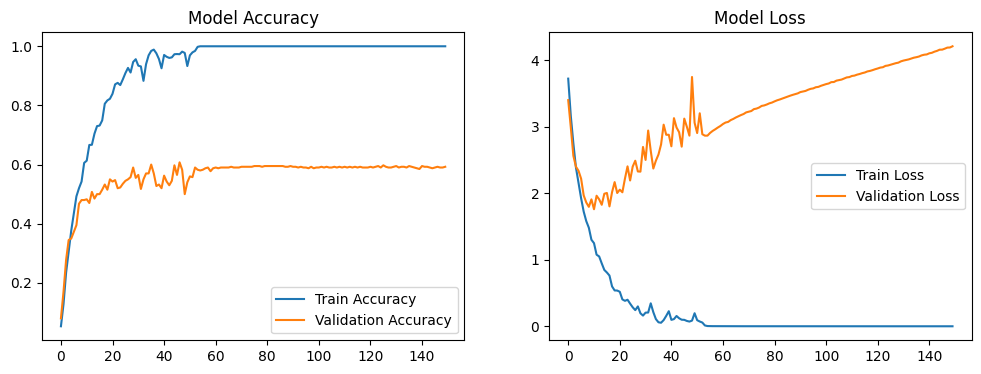

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.6135 - loss: 4.2529
Test Accuracy: 0.5925
Final Test Accuracy: 0.5925
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 1.0000
Validation Accuracy: 0.5925
Precision: 0.6237
Recall: 0.5925
F1-score: 0.5886
ESC-50 pre-trained model saved successfully!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

# Function to extract stacked features (MFCC + TZ)
def extract_features(file_path, sr=22050, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mfcc = resize_feature(mfcc, target_size)
        tonnetz = resize_feature(tonnetz, target_size)

        stacked_features = np.stack([mfcc, tonnetz], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=50)

# Resize images (Ensure uniformity)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Define CNN model based on the paper
def create_cnn_model(input_shape, num_classes=50):
    model = Sequential([
        Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),

        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train the CNN model
input_shape = (128, 128, 2)
num_classes = 50
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Print final test accuracy
print(f"Final Test Accuracy: {accuracy:.4f}")


from sklearn.metrics import classification_report, accuracy_score

# Extract final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels

# Compute classification metrics
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Save trained model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_ESC50.h5"
model.save(esc50_model_path)
print("ESC-50 pre-trained model saved successfully!")



In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


# Load pre-trained ESC-50 model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_ESC50.h5"
model = load_model(esc50_model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# Load UrbanSound8K metadata
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

metadata = pd.read_csv(urbansound_csv_path)

# Function to extract stacked features (MFCC + TZ)
def extract_features(file_path, sr=22050, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # Ensure uniform size
        mfcc = librosa.util.fix_length(mfcc, size=target_size[1], axis=1)
        mfcc = librosa.util.fix_length(mfcc, size=target_size[0], axis=0)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[1], axis=1)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[0], axis=0)

        stacked_features = np.stack([mfcc, tonnetz], axis=-1)

        if stacked_features.shape != (128, 128, 2):
            print(f"Feature shape mismatch for {file_path}: {stacked_features.shape}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare UrbanSound8K dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array([img for img in X if img is not None and img.shape == (128, 128, 2)])
y = to_categorical(y, num_classes=10)

if len(X) == 0:
    raise ValueError("No valid features extracted for UrbanSound8K. Check file paths and extract_features() function.")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modify last layer to match UrbanSound8K's 10 classes
model.pop()
model.add(Dense(10, activation='softmax'))

# Recompile and fine-tune
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:", report)

# Save fine-tuned model
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned UrbanSound8K model saved successfully!")


Pre-trained ESC-50 model loaded successfully!


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:10<2:25:04,  1.00it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=4

Error processing file /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav: Audio buffer is not finite everywhere


 95%|█████████▌| 8328/8732 [2:08:47<04:57,  1.36it/s]

Error processing file /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav: Audio buffer is not finite everywhere


 95%|█████████▌| 8329/8732 [2:08:48<04:46,  1.40it/s]

Error processing file /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav: Audio buffer is not finite everywhere


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
 95%|█████████▌| 8330/8732 [2:08:48<04:40,  1.43it/s]

Error processing file /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav: Audio buffer is not finite everywhere


 95%|█████████▌| 8338/8732 [2:08:55<05:36,  1.17it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=573
  warnings.warn(
 97%|█████████▋| 8435/8732 [2:10:25<04:36,  1.08it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=998
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=499
  warnings.warn(
 97%|█████████▋| 8462/8732 [2:10:50<04:10,  1.08it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=768
  warnings.warn(
 98%|█████████▊| 8535/8732 [2:11:58<02:59,  1.10it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=719
  warnings.warn(
 98%|████████

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 361ms/step - accuracy: 0.2987 - loss: 2.7027 - val_accuracy: 0.5699 - val_loss: 1.2628
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 341ms/step - accuracy: 0.6116 - loss: 1.1310 - val_accuracy: 0.6518 - val_loss: 1.0314
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 341ms/step - accuracy: 0.6917 - loss: 0.9268 - val_accuracy: 0.7050 - val_loss: 0.8974
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 337ms/step - accuracy: 0.7481 - loss: 0.7911 - val_accuracy: 0.7566 - val_loss: 0.7914
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step - accuracy: 0.7840 - loss: 0.6873 - val_accuracy: 0.7784 - val_loss: 0.7258
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - accuracy: 0.8053 - loss: 0.6108 - val_accuracy: 0.7950 - val_loss: 0.6788
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 354ms/step - accuracy: 0.8278 - loss: 0.5597 - val_accuracy: 0.8116 - val_loss: 0.6286
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 344ms/step - accuracy: 0.8443 - loss: 0

Classification Report:               precision    recall  f1-score   support

           0     0.9628    0.9241    0.9431       224
           1     0.9481    0.9241    0.9359        79
           2     0.8187    0.8613    0.8394       173
           3     0.8667    0.9055    0.8856       201
           4     0.9246    0.9020    0.9132       204
           5     0.9751    0.9800    0.9776       200
           6     0.9589    0.9333    0.9459        75
           7     0.9109    0.9634    0.9364       191
           8     0.9571    0.8814    0.9176       177
           9     0.8616    0.8694    0.8655       222

    accuracy                         0.9129      1746
   macro avg     0.9184    0.9144    0.9160      1746
weighted avg     0.9144    0.9129    0.9133      1746

Fine-tuned UrbanSound8K model saved successfully!


219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.9942 - loss: 0.0313
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9087 - loss: 0.3801
Training Accuracy: 0.9930
Validation Accuracy: 0.9129
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step
Precision: 0.9184
Recall: 0.9144
F1 Score: 0.9160
Classification Report:               precision    recall  f1-score   support

           0     0.9628    0.9241    0.9431       224
           1     0.9481    0.9241    0.9359        79
           2     0.8187    0.8613    0.8394       173
           3     0.8667    0.9055    0.8856       201
           4     0.9246    0.9020    0.9132       204
           5     0.9751    0.9800    0.9776       200
           6     0.9589    0.9333    0.9459        75
           7     0.9109    0.9634    0.9364       191
           8     0.9571    0.8814    0.9176       177
           9     0.8616    0.8694    0.8655       222

    accuracy                         0.9129      1746
   macro avg     0.9184    0.91

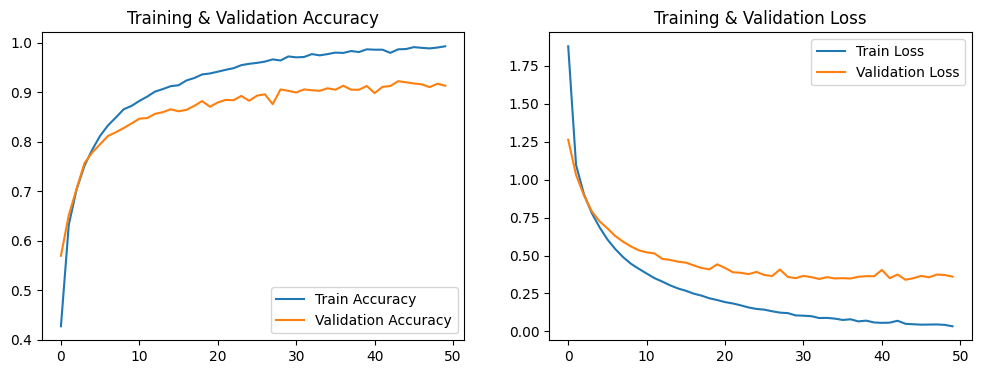

Fine-tuned UrbanSound8K model saved successfully!


In [ ]:
# Evaluate model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:", report)

# Plot Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Save fine-tuned model
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned UrbanSound8K model saved successfully!")


Pre-trained ESC-50 model loaded successfully!


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:03<50:37,  2.87it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=447

Error processing /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav: Audio buffer is not finite everywhere


 41%|████      | 3590/8732 [21:02<27:13,  3.15it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=989
  warnings.warn(
 41%|████      | 3595/8732 [21:03<27:15,  3.14it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=879
  warnings.warn(
 41%|████      | 3596/8732 [21:03<26:33,  3.22it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=905
  warnings.warn(
 41%|████      | 3599/8732 [21:05<33:57,  2.52it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=907
  warnings.warn(
 41%|████▏     | 3604/8732 [21:07<37:35,  2.27it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal o

Extracted features: (8731, 128, 128, 2), Labels: (8731, 10)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 569ms/step - accuracy: 0.3082 - loss: 2.5740 - val_accuracy: 0.5793 - val_loss: 1.2191
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 116s 525ms/step - accuracy: 0.6252 - loss: 1.1078 - val_accuracy: 0.6640 - val_loss: 0.9868
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 113s 515ms/step - accuracy: 0.7018 - loss: 0.8796 - val_accuracy: 0.6989 - val_loss: 0.8663
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 144s 523ms/step - accuracy: 0.7432 - loss: 0.7673 - val_accuracy: 0.7373 - val_loss: 0.7996
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 113s 518ms/step - accuracy: 0.7811 - loss: 0.6622 - val_accuracy: 0.7796 - val_loss: 0.7076
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 144s 525ms/step - accuracy: 0.8153 - loss: 0.5879 - val_accuracy: 0.7928 - val_loss: 0.6590
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 529ms/step - accuracy: 0.8319 - loss: 0.5461 - val_accuracy: 0.8002 - val_loss: 0.6115
Epoch 8/50
219/2

Precision: 0.9141
Recall: 0.9209
F1 Score: 0.9167
Classification Report:
               precision    recall  f1-score   support

           0     0.9710    0.9437    0.9571       213
           1     0.8519    0.9324    0.8903        74
           2     0.8714    0.9059    0.8883       202
           3     0.9424    0.8696    0.9045       207
           4     0.9227    0.8647    0.8928       207
           5     0.9234    0.9797    0.9507       197
           6     0.9333    0.9722    0.9524        72
           7     0.8685    0.9487    0.9069       195
           8     0.9695    0.9353    0.9521       170
           9     0.8867    0.8571    0.8717       210

    accuracy                         0.9153      1747
   macro avg     0.9141    0.9209    0.9167      1747
weighted avg     0.9167    0.9153    0.9152      1747

Fine-tuned model saved!


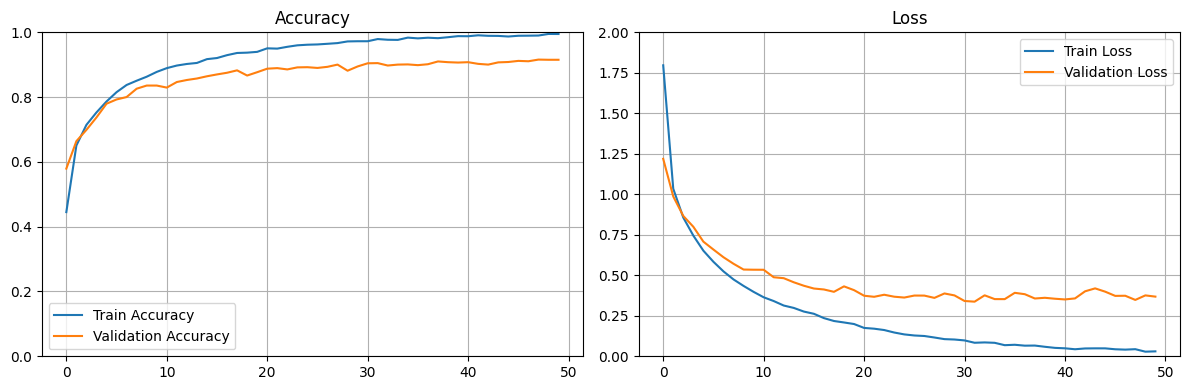

CNN1 training history saved!


In [ ]:
import os
import numpy as np
np.complex = complex  # Fix for compatibility with librosa and newer numpy

import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from tqdm import tqdm

# ============================
# Load pre-trained ESC-50 model
# ============================
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_ESC50.h5"
model = load_model(esc50_model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# ============================
# Load UrbanSound8K metadata
# ============================
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
metadata = pd.read_csv(urbansound_csv_path)

# ============================
# Feature Extraction Function (MFCC + Tonnetz)
# ============================
def extract_features(file_path, sr=22050, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # Fix shape to target
        mfcc = librosa.util.fix_length(mfcc, size=target_size[1], axis=1)
        mfcc = librosa.util.fix_length(mfcc, size=target_size[0], axis=0)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[1], axis=1)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[0], axis=0)

        stacked_features = np.stack([mfcc, tonnetz], axis=-1)

        if stacked_features.shape != (128, 128, 2):
            print(f"Feature shape mismatch: {stacked_features.shape}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ============================
# Load and Prepare Dataset
# ============================
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=10)

print(f"Extracted features: {X.shape}, Labels: {y.shape}")

if len(X) == 0:
    raise ValueError("No valid features extracted.")

# ============================
# Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================
# Modify Last Layer
# ============================
model.pop()
model.add(Dense(10, activation='softmax', name="urban_output"))

# ============================
# Compile and Train
# ============================
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# ============================
# Evaluate and Report
# ============================
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))

# ============================
# Save Fine-Tuned Model
# ============================
model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_MFCC_TZ_UrbanSound8K.h5"
model.save(model_path)
print("Fine-tuned model saved!")

# ============================
# Plot Training History
# ============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Save Training History as .npy
# ============================
result_dir = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_dir, "cnn1_MFCC_TZ_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_dir, "cnn1_MFCC_TZ_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_dir, "cnn1_MFCC_TZ_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_dir, "cnn1_MFCC_TZ_val_loss.npy"), history.history['val_loss'])

print("CNN1 training history saved!")
